# Electricity Demand Forecasting

## <table id='Table_Of_Contents'>Table Of Contents</table>

1. [Import Modules](#import)<br>
2. [Read Data File](#read_data)<br>
    1. [Clean Data Frame](#clean_data)<br>
    2. [Data Split](#data_split)<br>




### <a id='import'> 1. Import Modules</a>

In [1]:
import pandas as pd
import numpy as np
import re

import json
import datetime


from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler

#from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

import pickle
import warnings

from dateutil import parser

import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.statespace.mlemodel

In [2]:
warnings.filterwarnings('ignore')

### 2. Data Import <a id='read_data'></a>

In [3]:
data_file = '../data/big_demand_temp_train_by_day.csv'

In [4]:
full_df = pd.read_csv(data_file, index_col=0)
full_df.head()

,day_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW
2015-07-06,834762.0,13845790.0,76.53,69.43,79.45,68.22,91.88,95.83,0.0
2015-07-07,825173.0,13845790.0,77.05,69.61,79.38,68.29,90.67,92.31,1.0
2015-07-08,804819.0,13845790.0,73.90,70.08,74.78,64.59,86.60,91.83,2.0
2015-07-09,782610.0,13845790.0,74.22,71.30,74.00,63.23,78.27,88.91,3.0
2015-07-10,769752.0,13845790.0,74.57,73.32,73.66,68.02,78.92,82.60,4.0


#### 2.A Clean the data frame <a id='clean_data'></a>

In [5]:
# Convert the time string to a datetime object
full_df.index = pd.DatetimeIndex(full_df.index)
full_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 852 entries, 2015-07-06 to 2017-11-03
Data columns (total 9 columns):
day_demand    852 non-null float64
CA_pop        852 non-null float64
la_high       852 non-null float64
sd_high       852 non-null float64
sj_high       852 non-null float64
sf_high       852 non-null float64
sac_high      852 non-null float64
f_high        852 non-null float64
DOW           852 non-null float64
dtypes: float64(9)
memory usage: 66.6 KB


In [6]:
full_df.head()

,day_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW
2015-07-06,834762.0,13845790.0,76.53,69.43,79.45,68.22,91.88,95.83,0.0
2015-07-07,825173.0,13845790.0,77.05,69.61,79.38,68.29,90.67,92.31,1.0
2015-07-08,804819.0,13845790.0,73.90,70.08,74.78,64.59,86.60,91.83,2.0
2015-07-09,782610.0,13845790.0,74.22,71.30,74.00,63.23,78.27,88.91,3.0
2015-07-10,769752.0,13845790.0,74.57,73.32,73.66,68.02,78.92,82.60,4.0


#### 2.B Extending Exogenous Regressors To Include Day Of Week <a id='extend_dow'></a>

In [7]:
days = full_df['DOW']
days_df = pd.get_dummies(days)
days_df.columns=['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
days_df.index = full_df.index
new_df = pd.concat([full_df, days_df], axis=1)
col_names = []
col_names.extend(full_df.columns)
col_names.extend(days_df.columns)
new_df.columns = col_names
new_df.head()

,day_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW,Mon,Tue,Wed,Thur,Fri,Sat,Sun
2015-07-06,834762.0,13845790.0,76.53,69.43,79.45,68.22,91.88,95.83,0.0,1,0,0,0,0,0,0
2015-07-07,825173.0,13845790.0,77.05,69.61,79.38,68.29,90.67,92.31,1.0,0,1,0,0,0,0,0
2015-07-08,804819.0,13845790.0,73.90,70.08,74.78,64.59,86.60,91.83,2.0,0,0,1,0,0,0,0
2015-07-09,782610.0,13845790.0,74.22,71.30,74.00,63.23,78.27,88.91,3.0,0,0,0,1,0,0,0
2015-07-10,769752.0,13845790.0,74.57,73.32,73.66,68.02,78.92,82.60,4.0,0,0,0,0,1,0,0


#### 2.C Data Split <a id='data_split'></a>

In [8]:
# Split the data into training and test sections
data_len = new_df.shape[0]

In [9]:
# Split the data frame into two parts
train_len = int(0.7 * data_len)
window_len = int(0.1 * data_len)

In [10]:
# Make the primary train/validation split
X_train = new_df.iloc[:train_len, :]

# Make intermediate trail windows for walk forward validation
X_walk1 = new_df.iloc[train_len:train_len+window_len, :]
X_walk2 = new_df.iloc[train_len+window_len:train_len+2*window_len, :]
X_walk3 = new_df.iloc[train_len+2*window_len:train_len+3*window_len, :]

In [11]:
# Look at the dataframe contents
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 596 entries, 2015-07-06 to 2017-02-20
Data columns (total 16 columns):
day_demand    596 non-null float64
CA_pop        596 non-null float64
la_high       596 non-null float64
sd_high       596 non-null float64
sj_high       596 non-null float64
sf_high       596 non-null float64
sac_high      596 non-null float64
f_high        596 non-null float64
DOW           596 non-null float64
Mon           596 non-null uint8
Tue           596 non-null uint8
Wed           596 non-null uint8
Thur          596 non-null uint8
Fri           596 non-null uint8
Sat           596 non-null uint8
Sun           596 non-null uint8
dtypes: float64(9), uint8(7)
memory usage: 50.6 KB


### 3. Helper Functions <a id='helper'></a>

In [12]:
# This funtion tests the stationarity of the data set
#   The function was originally published as part of the Blog post
#
#   https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba
#
#
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [13]:
from collections import defaultdict
def order_sweep(model, arima_order_list, seasonal_order_list, endo_data, exo_data=None) :
    aic_dict = defaultdict(dict)
    i=0
    for order in arima_order_list :
        for seasonal in seasonal_order_list :
            if exo_data is not None :
                mod = model(endo_data, order=order, seasonal_order=seasonal, exog=exo_data)
            else :
                mod = model(endo_data, order=order, seasonal_order=seasonal)
                
            try :
                res = mod.fit()
                aic_dict[i] = {'order': order, 'seasonal order': seasonal, 
                    'aic': res.aic, 'bic':res.bic, 'mse': res.mse}
            except :
                continue
                
            i += 1
    return aic_dict

In [14]:
def top_results(result_dict, test_key, count) :
    top_result = [1000000]*count
    order_list = [0]*count
    ret_results = []
    for i in result_dict.keys() :
        if result_dict[i][test_key] < max(top_result) :
            top_result[top_result.index(max(top_result))] = result_dict[i][test_key]
            order_list[top_result.index(max(top_result))] = i
            
    for idx in order_list :
        ret_results.append(result_dict[idx])
        
    return sorted(ret_results, key=lambda x : x[test_key])
        

### 4. Data Analysis <a id='analysis'></a>

#### 4.1 Stationarity Testing <a id='stationarity'></a>

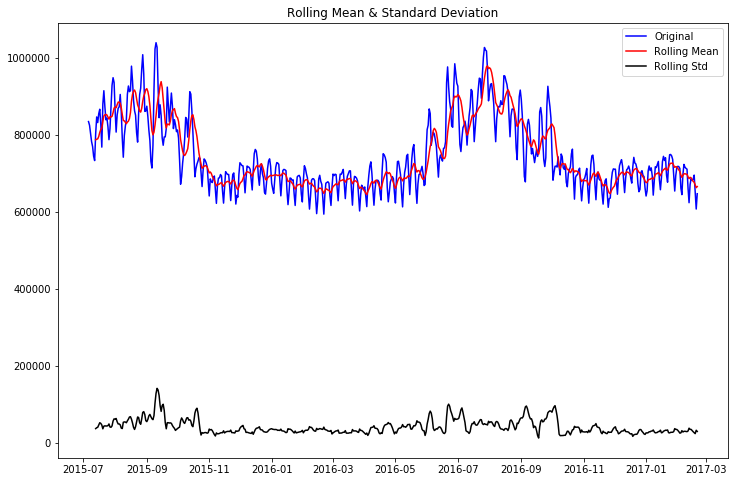

Results of Dickey-Fuller Test:
p-value = 0.4712. The series is likely non-stationary.
Test Statistic                  -1.622938
p-value                          0.471189
#Lags Used                      15.000000
Number of Observations Used    580.000000
Critical Value (1%)             -3.441675
Critical Value (5%)             -2.866536
Critical Value (10%)            -2.569431
dtype: float64


In [15]:
test_stationarity(X_train.day_demand, window=8)

Daily data is not stationary.  Try a simple difference to see if we can get a stationary result

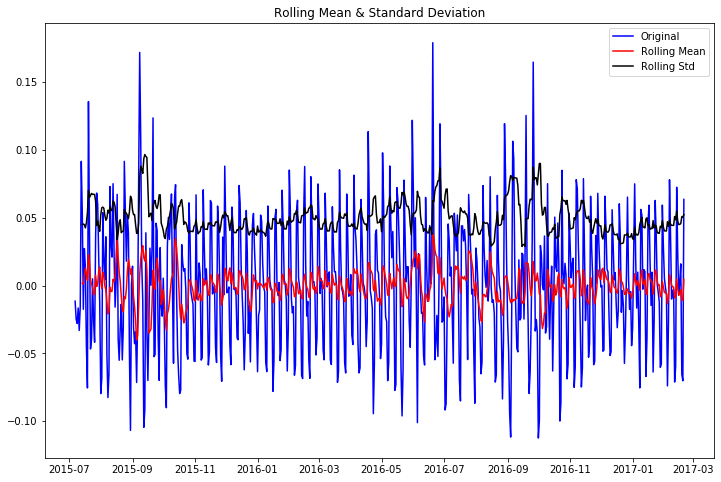

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -5.773402e+00
p-value                        5.327534e-07
#Lags Used                     2.000000e+01
Number of Observations Used    5.740000e+02
Critical Value (1%)           -3.441794e+00
Critical Value (5%)           -2.866588e+00
Critical Value (10%)          -2.569459e+00
dtype: float64


In [16]:
diff_demand_day = X_train.day_demand.diff()[1:]
log_demand = np.log(X_train.day_demand)

test_stationarity(log_demand.diff()[1:], window=8)

Need to take the log of the daily demand to get a stationary time series

#### 4.2 Autocorrelation <a id='autocorr'></a>

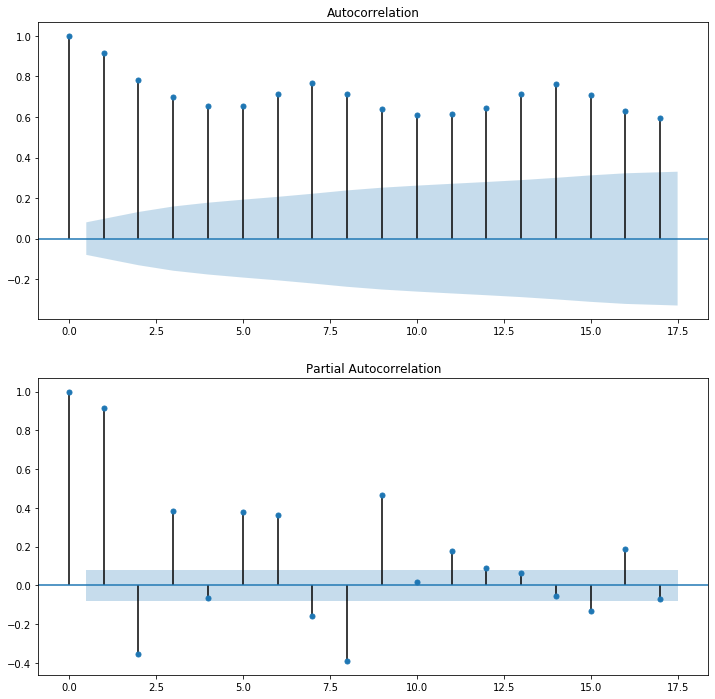

In [17]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(log_demand, lags=7+10, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(log_demand, lags=7+10, ax=ax2)# , lags=40

#### 4.3 Seasonal Decomposition <a id='seasonal_decomp'></a>

In [18]:
# Do seasonal decopostion on the weekly periodic features
decomp_data = seasonal_decompose(log_demand, period=7, model='additive')

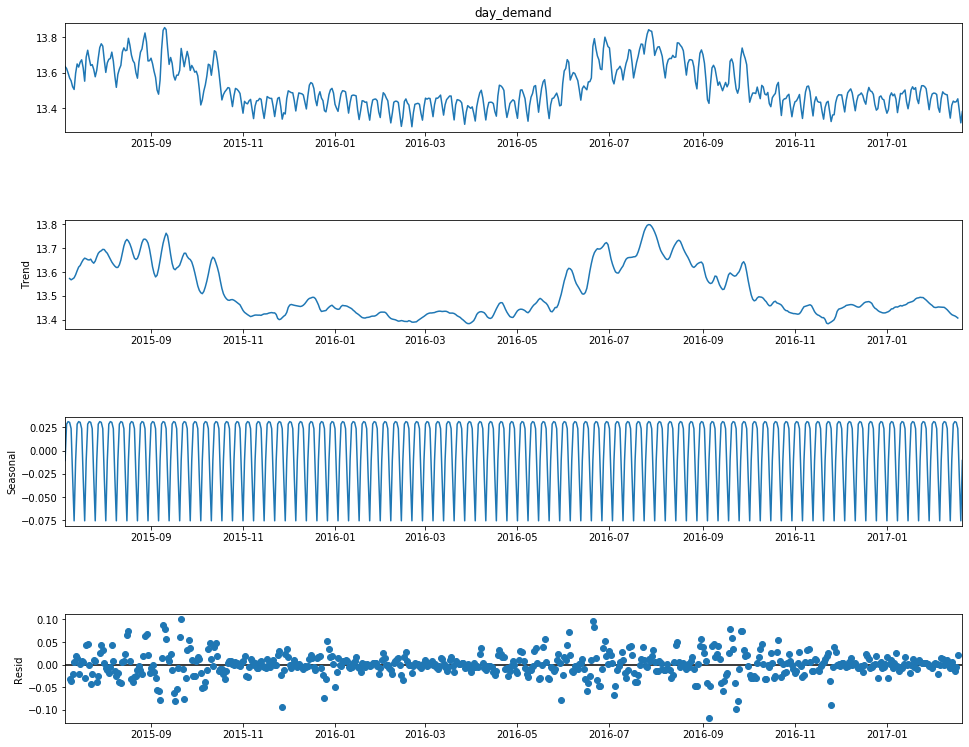

In [19]:
fig = decomp_data.plot()
fig.set_size_inches(15, 12)

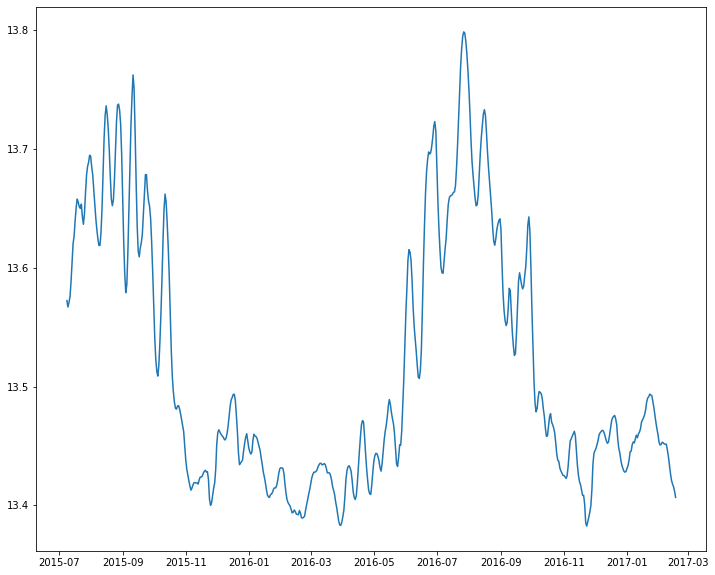

In [20]:
# Plot a closeup of the seasonal component
fig = plt.figure(figsize=[12,10])
plt.plot(decomp_data.trend[:10000])

#### 4.4 Trend Autocorrelation <a id='trend_auto'></a>

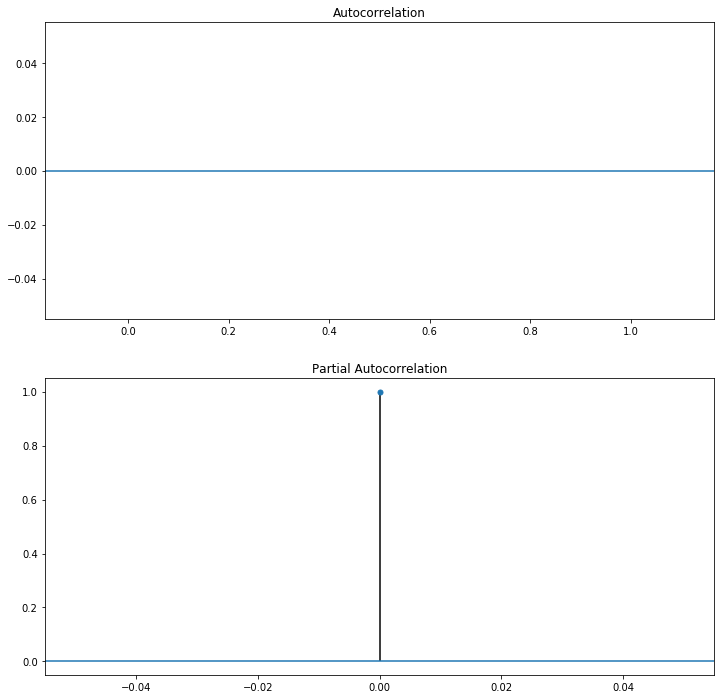

In [21]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(decomp_data.trend, lags=24*7+10, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(decomp_data.trend, lags=24*7+10, ax=ax2)

In [22]:
# Add Log_demand to the dataframe
X_train['log_demand'] = np.log(X_train['day_demand'])

### 5. Modeling <a id='modeling'></a>

#### 5.1 SARIMAX Without Exogeneous Data <a id='SARI_NoX'></a>

In [23]:
# Define the model for SARIMAX just using the demand data
order_list =[(3,0,0),
             (4,0,0),
             (5,0,0),
             (3,1,0),
             (4,1,0),
             (5,1,0),
             (3,0,1),
             (4,0,1),
             (5,0,1),
             (3,1,1),
             (4,1,1),
             (5,1,1)]

# Define the model for SARIMAX just using the demand data
seasonal_list =[(3,0,0, 7),
                (4,0,0, 7),
                (5,0,0, 7),
                (3,1,0, 7),
                (4,1,0, 7),
                (5,1,0, 7),
                (3,0,1, 7),
                (4,0,1, 7),
                (5,0,1, 7),
                (3,1,1, 7),
                (4,1,1, 7),
                (5,1,1, 7)]

result_dict = order_sweep(SARIMAX, order_list, seasonal_list,  endo_data=X_train['log_demand'])

#res1 = seasonal_model1.fit()

In [24]:
for result in top_results(result_dict, 'aic', 5) :
    print(result)
    
#for result in result_dict.keys() :
#    print(result_dict[result])

{'order': (5, 1, 1), 'seasonal order': (3, 1, 1, 7), 'aic': -2620.060097135175, 'bic': -2571.934824117066, 'mse': 0.3891466865374257}
{'order': (4, 1, 1), 'seasonal order': (5, 1, 1, 7), 'aic': -2616.4502827421557, 'bic': -2563.9499849042186, 'mse': 0.3891475317891638}
{'order': (4, 1, 1), 'seasonal order': (5, 0, 0, 7), 'aic': -2611.7101067444623, 'bic': -2563.4544342314734, 'mse': 0.31315593579424783}
{'order': (4, 1, 0), 'seasonal order': (3, 1, 1, 7), 'aic': -2611.5206967239865, 'bic': -2572.1454733455334, 'mse': 0.38916358066445006}
{'order': (4, 0, 0), 'seasonal order': (4, 0, 1, 7), 'aic': -2601.644496185563, 'bic': -2557.758882130107, 'mse': 0.31316341501680744}


In [25]:
for result in top_results(result_dict, 'bic', 5) :
    print(result)
    
#for result in result_dict.keys() :
#    print(result_dict[result])

{'order': (4, 1, 1), 'seasonal order': (3, 1, 1, 7), 'aic': -2628.776151962892, 'bic': -2585.025903764611, 'mse': 0.38914113955913704}
{'order': (5, 1, 0), 'seasonal order': (3, 1, 1, 7), 'aic': -2622.8977666812407, 'bic': -2579.1475184829596, 'mse': 0.3891465143259657}
{'order': (4, 1, 0), 'seasonal order': (3, 1, 1, 7), 'aic': -2611.5206967239865, 'bic': -2572.1454733455334, 'mse': 0.38916358066445006}
{'order': (4, 0, 0), 'seasonal order': (3, 1, 1, 7), 'aic': -2594.3234171941363, 'bic': -2554.9328746630486, 'mse': 2.1678956550128223}
{'order': (3, 0, 0), 'seasonal order': (5, 0, 1, 7), 'aic': -2597.727159371804, 'bic': -2553.841545316348, 'mse': 0.313167164067974}


In [26]:
for result in top_results(result_dict, 'mse', 5) :
    print(result)
    
#for result in result_dict.keys() :
#    print(result_dict[result])

{'order': (5, 0, 0), 'seasonal order': (4, 0, 1, 7), 'aic': -2623.5311520876785, 'bic': -2575.2569766266765, 'mse': 0.3131370302256747}
{'order': (4, 1, 1), 'seasonal order': (5, 0, 0, 7), 'aic': -2611.7101067444623, 'bic': -2563.4544342314734, 'mse': 0.31315593579424783}
{'order': (5, 0, 1), 'seasonal order': (4, 0, 1, 7), 'aic': -2603.554009473667, 'bic': -2550.8912726071194, 'mse': 0.3131590617238827}
{'order': (4, 0, 1), 'seasonal order': (4, 0, 1, 7), 'aic': -2602.649639932948, 'bic': -2554.375464471946, 'mse': 0.31316030916548615}
{'order': (4, 0, 0), 'seasonal order': (4, 0, 1, 7), 'aic': -2601.644496185563, 'bic': -2557.758882130107, 'mse': 0.31316341501680744}


In [23]:
# Now choose the results that seem to work the best above and fit the model
best_order1 = (4, 1, 1)
best_seasonal_order1 = (5, 0, 0, 7)
model1 = SARIMAX(X_train['log_demand'], order=best_order1, seasonal_order=best_seasonal_order1)
res1 = model1.fit()

In [24]:
print(res1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         log_demand   No. Observations:                  595
Model:             SARIMAX(4, 1, 1)x(5, 0, [], 7)   Log Likelihood                1316.855
Date:                            Sat, 21 Mar 2020   AIC                          -2611.710
Time:                                    22:48:40   BIC                          -2563.454
Sample:                                07-06-2015   HQIC                         -2592.917
                                     - 02-19-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3853      0.058     23.828      0.000       1.271       1.499
ar.L2         -0.7994      0.072   

In [25]:
res1.aic, res1.bic, res1.mse

(-2611.7101067444623, -2563.4544342314734, 0.31315593579424783)

In [26]:
# Save the trained model
filename = 'SARIMAX_wo_exog_day.sav'
pickle.dump(model1, open(filename, 'wb'))

In [27]:
demand_hat = np.exp(res1.fittedvalues)

##### 5.1.1 SARIMAX Without Exogeneous Data - Fit Plot Close <a id='plot-SARI_fit_zoom'></a>

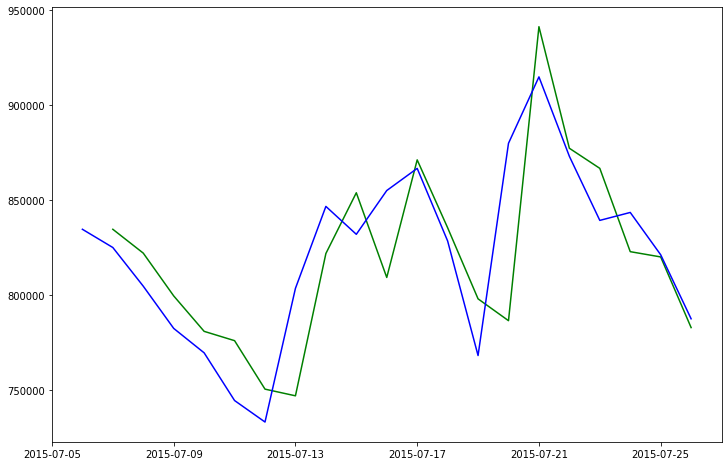

In [28]:
fig = plt.figure(figsize=[12, 8])
close_window = 3*7

plt.plot(demand_hat[1:close_window], label='Predicted', c='g')
plt.plot(X_train.index[:close_window], X_train['day_demand'].values[:close_window], \
         c='b', label='Actual (train)')

##### 5.1.2 SARIMAX Without Exogeneous Data - Fit Plot 3 Months  <a id='plot-SARI_fit_wide'></a>

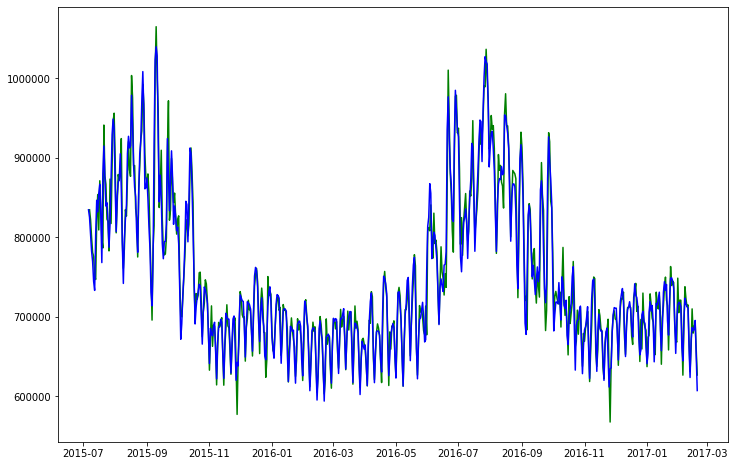

In [29]:
fig = plt.figure(figsize=[12, 8])

plt.plot(demand_hat[1:1000], c='g')
plt.plot(X_train.index[0:1000], X_train['day_demand'].values[0:1000], c='b')

----
----

##### 5.1.3 SARIMAX Without Exogeneous Data - Forecast <a id='forecast-SARI_nox'></a>

----

In [30]:
predict_steps = 7*3
predict1 = res1.get_forecast(predict_steps)
pred_ci1 = np.exp(predict1.conf_int(alpha=0.5))
pred_vals1 = np.exp(predict1.predicted_mean)

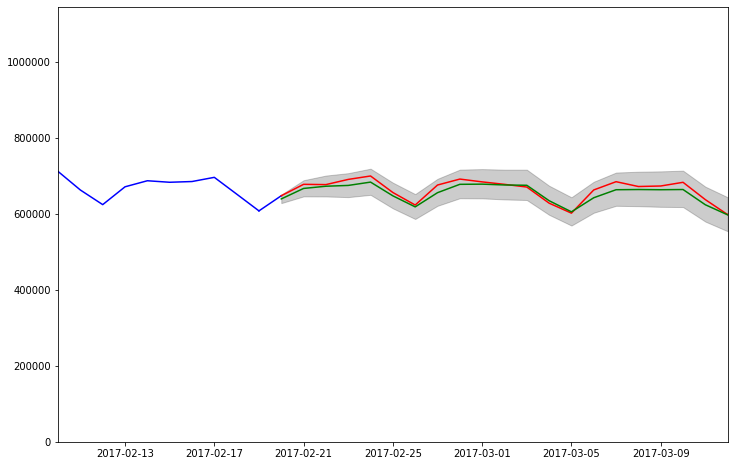

In [31]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(0, 15000)
date_list = X_train.index

low_values = pred_ci1.iloc[:, 0].values
high_values = pred_ci1.iloc[:, 1].values
pred_times1 = pred_ci1.index

plt.xlim(min(date_list[int(-0.5*predict_steps):]), max(pred_times1))
plt.ylim(0, max([max(high_values), 1.1*max(max(X_train['day_demand']), max(X_walk1['day_demand']))]))

plt.plot(X_train.index[-2*predict_steps:], X_train['day_demand'].values[-2*predict_steps:], c='b')
plt.plot([X_train.index[-1], X_walk1['day_demand'].index[0]], \
          [X_train['day_demand'].values[-1], X_walk1['day_demand'].values[0]], c='b')
plt.plot(X_walk1.index, X_walk1['day_demand'].values, c='r')
plt.plot(pred_times1, pred_vals1.values, c='g')


plt.fill_between(pred_times1, low_values, high_values, color='k', alpha=0.2)

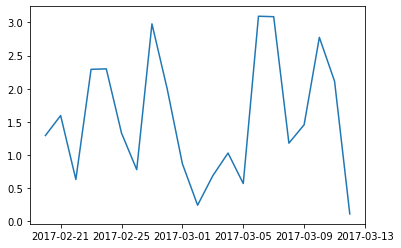

In [32]:
residuals = [abs(X_walk1['day_demand'].values[x] - pred_vals1.values[x]) for x in range(len(pred_vals1))]
percent_error = [residuals[x]/X_walk1['day_demand'].values[x]*100 for x in range(len(residuals))]
plt.plot(pred_times1, percent_error)
#plt.ylim(0, 7000)

In [34]:
mape1 = np.mean(percent_error[:21])
print(mape1)

1.543524004560698


#### 5.2 SARIMAX With Exogeneous Data <a id='model-SARIMAX-wexog'></a>

In [35]:
# The trailing columns are city temperatures and state population
important_cities = ['la_high',  'f_high']

In [41]:
# Define the model for SARIMAX just using the demand data
order_list =[(3,0,0),
             (4,0,0),
             (5,0,0),
             (3,1,0),
             (4,1,0),
             (5,1,0),
             (3,0,1),
             (4,0,1),
             (5,0,1),
             (3,1,1),
             (4,1,1)]

# Define the model for SARIMAX just using the demand data
seasonal_list =[(3,0,0, 7),
                (4,0,0, 7),
                (5,0,0, 7),
                (3,1,0, 7),
                (4,1,0, 7),
                (5,1,0, 7),
                (3,0,1, 7),
                (4,0,1, 7),
                (5,0,1, 7)]

result_dict = order_sweep(SARIMAX, order_list, seasonal_list,  \
        endo_data=X_train['log_demand'], exo_data=X_train[important_cities])

#res1 = seasonal_model1.fit()

In [42]:
for result in top_results(result_dict, 'aic', 5) :
    print(result)
    
#for result in result_dict.keys() :
#    print(result_dict[result])

{'order': (5, 1, 0), 'seasonal order': (5, 0, 0, 7), 'aic': -2624.29085102115, 'bic': -2567.2614198694355, 'mse': 0.3044921961913979}
{'order': (3, 0, 1), 'seasonal order': (5, 1, 0, 7), 'aic': -2623.0730454450513, 'bic': -2570.552322070268, 'mse': 2.11263592579788}
{'order': (4, 0, 1), 'seasonal order': (5, 1, 0, 7), 'aic': -2619.1500409887576, 'bic': -2562.2525906660753, 'mse': 2.111103247256136}
{'order': (5, 0, 0), 'seasonal order': (5, 1, 0, 7), 'aic': -2618.5633929464457, 'bic': -2561.6659426237634, 'mse': 2.114150452119597}
{'order': (3, 0, 1), 'seasonal order': (4, 1, 0, 7), 'aic': -2617.529582547755, 'bic': -2569.3855861208704, 'mse': 2.109174628201511}


In [43]:
for result in top_results(result_dict, 'bic', 5) :
    print(result)
    
#for result in result_dict.keys() :
#    print(result_dict[result])

{'order': (3, 0, 1), 'seasonal order': (5, 1, 0, 7), 'aic': -2623.0730454450513, 'bic': -2570.552322070268, 'mse': 2.11263592579788}
{'order': (3, 0, 0), 'seasonal order': (4, 1, 0, 7), 'aic': -2613.4570493727624, 'bic': -2569.689779893776, 'mse': 2.110929362168968}
{'order': (3, 0, 1), 'seasonal order': (4, 1, 0, 7), 'aic': -2617.529582547755, 'bic': -2569.3855861208704, 'mse': 2.109174628201511}
{'order': (5, 1, 0), 'seasonal order': (5, 0, 0, 7), 'aic': -2624.29085102115, 'bic': -2567.2614198694355, 'mse': 0.3044921961913979}
{'order': (3, 0, 0), 'seasonal order': (3, 1, 0, 7), 'aic': -2592.2657150101786, 'bic': -2552.875172479091, 'mse': 2.113384935389353}


In [44]:
for result in top_results(result_dict, 'mse', 5) :
    print(result)
    
#for result in result_dict.keys() :
#    print(result_dict[result])

{'order': (5, 0, 1), 'seasonal order': (3, 0, 0, 7), 'aic': -2348.871902595964, 'bic': -2296.2091657294163, 'mse': 0.3006853744415113}
{'order': (3, 0, 0), 'seasonal order': (3, 0, 0, 7), 'aic': -2190.2759793164923, 'bic': -2150.778926666582, 'mse': 0.30189199783451914}
{'order': (4, 0, 1), 'seasonal order': (5, 0, 0, 7), 'aic': -2429.814943977898, 'bic': -2372.7636457058047, 'mse': 0.30196516740808726}
{'order': (3, 1, 0), 'seasonal order': (4, 0, 1, 7), 'aic': -2562.9689219800166, 'bic': -2514.7132494670277, 'mse': 0.3034798311597659}
{'order': (4, 0, 0), 'seasonal order': (4, 0, 0, 7), 'aic': -2294.5696906458775, 'bic': -2246.2955151848755, 'mse': 0.3045923690626125}


In [36]:
# Now choose the results that seem to work the best above and fit the model
best_order2 = (3, 0, 1)
best_seasonal_order2 = (3, 0, 0, 7)
model2 = SARIMAX(X_train['log_demand'], order=best_order2, seasonal_order=best_seasonal_order2, exog=X_train[important_cities])
res2 = model2.fit()

In [37]:
print(res2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         log_demand   No. Observations:                  595
Model:             SARIMAX(3, 0, 1)x(3, 0, [], 7)   Log Likelihood                1186.369
Date:                            Sat, 21 Mar 2020   AIC                          -2352.738
Time:                                    22:50:38   BIC                          -2308.852
Sample:                                07-06-2015   HQIC                         -2335.648
                                     - 02-19-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
la_high        0.0004      0.000      1.442      0.149      -0.000       0.001
f_high         0.0014      0.000   

In [38]:
# Save the trained model
filename = 'SARIMAX_w_exog_day.sav'
pickle.dump(model2, open(filename, 'wb'))

In [39]:
res2.aic

-2352.7380325605154

In [40]:
demand_hat2 = np.exp(res2.fittedvalues)

##### 5.2.1 SARIMAX With Exogeneous Data - Fit Plot Close <a id='plot-SARI_exog_fit_zoom'></a>

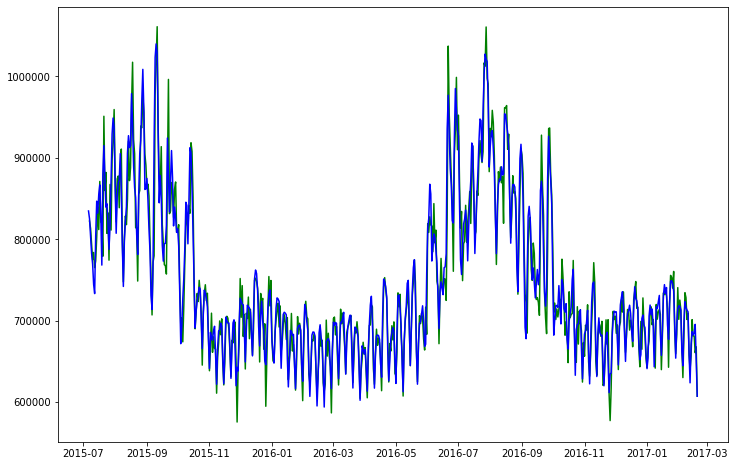

In [41]:
fig = plt.figure(figsize=[12, 8])

#plt.ylim(25000, 55000)

plt.plot(demand_hat2[1:], c='g')
plt.plot(X_train.index, X_train['day_demand'].values, c='b')

----
----

##### 5.2.2 SARIMAX With Exogeneous Data - Fit Plot 3 Month <a id='plot-SARI_exof_fit_wide'></a>

----

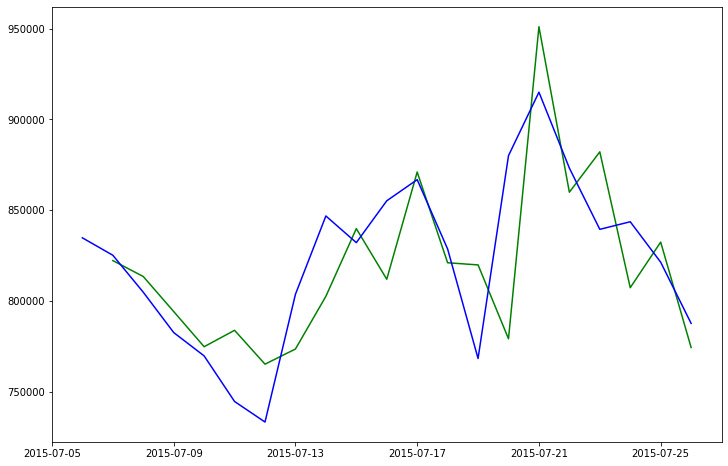

In [42]:
fig = plt.figure(figsize=[12, 8])

#plt.ylim(0, 55000)

plt.plot(demand_hat2[1:21], label='Prediction', c='g')
actual = X_train['day_demand'].values
plt.plot(X_train.index[:21], X_train['day_demand'].values[:21], c='b', label='Actual')

----
----
##### 5.2.3 SARIMAX With Exogeneous Data - Forecast  <a id='forecast-SARI_exog'></a>
----

In [43]:
predict_steps = 7*4
predict2 = res2.get_forecast(predict_steps, 
                exog=X_walk1[important_cities].values[:predict_steps, :])
pred_ci2 = np.exp(predict2.conf_int(alpha=0.5))
pred_vals2 = np.exp(predict2.predicted_mean)

In [44]:
aic2 = res2.aic

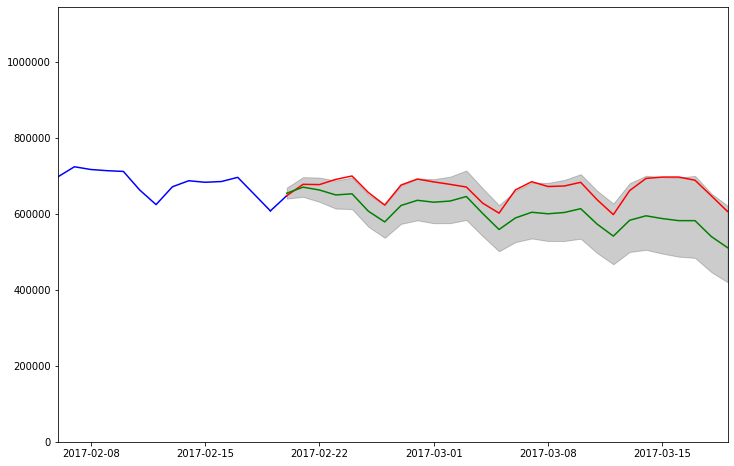

In [45]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(0, 15000)
date_list = X_train.index

low_values = pred_ci2.iloc[:, 0].values
high_values = pred_ci2.iloc[:, 1].values
pred_times2 = pred_ci2.index

plt.xlim(min(date_list[int(-0.5*predict_steps):]), max(pred_times2))
plt.ylim(0, max([max(high_values), 1.1*max(max(X_train['day_demand']), max(X_walk1['day_demand']))]))

plt.plot(X_train.index[-2*predict_steps:], X_train['day_demand'].values[-2*predict_steps:], c='b')
plt.plot([X_train.index[-1], X_walk1['day_demand'].index[0]], \
          [X_train['day_demand'].values[-1], X_walk1['day_demand'].values[0]], c='b')
plt.plot(X_walk1.index, X_walk1['day_demand'].values, c='r')
plt.plot(pred_times2, pred_vals2.values, c='g')


plt.fill_between(pred_times2, low_values, high_values, color='k', alpha=0.2)

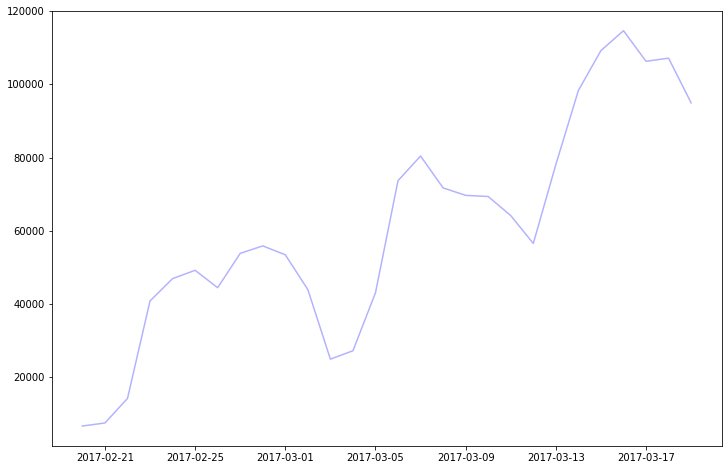

In [46]:
fig = plt.figure(figsize=[12, 8])
residuals2 = [abs(X_walk1['day_demand'].values[x] - pred_vals2.values[x]) for x in range(len(pred_vals2))]
plt.plot(pred_times2, residuals2, c='b', alpha=0.3)
#plt.ylim(0, 10000)

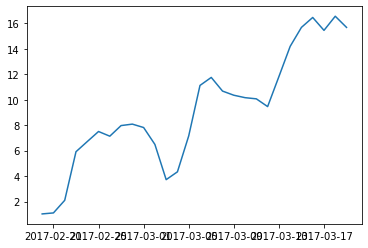

In [47]:
residuals = [abs(X_walk1['day_demand'].values[x] - pred_vals2.values[x]) for x in range(len(pred_vals2))]
percent_error = [residuals[x]/X_walk1['day_demand'].values[x]*100 for x in range(len(residuals))]
plt.plot(pred_times2, percent_error)
#plt.ylim(0, 7000)

In [48]:
mape2 = np.mean(percent_error[:21])
print(mape2)

7.174017446435402


----
----
#### 5.3 SARIMAX With Extended Exogeneous Data <a id='model-SARI-xexog'></a>
----

In [49]:
# Use all the dummies for the day of the week but don't use the DOW column
all_exog_columns = X_train.columns[1:-1]

In [50]:
# Define the model for SARIMAX just using the demand data
order_list =[(3,0,0),
             (4,0,0),
             (5,0,0),
             (3,1,0),
             (4,1,0),
             (5,1,0),
             (3,0,1),
             (4,0,1),
             (5,0,1),
             (3,1,1),
             (4,1,1)]

# Define the model for SARIMAX just using the demand data
seasonal_list =[(3,0,0, 7),
                (4,0,0, 7),
                (5,0,0, 7),
                (3,1,0, 7),
                (4,1,0, 7),
                (5,1,0, 7),
                (3,0,1, 7),
                (4,0,1, 7),
                (5,0,1, 7)]

result_dict = order_sweep(SARIMAX, order_list, seasonal_list,  \
        endo_data=X_train['log_demand'], exo_data=X_train[all_exog_columns])

#res1 = seasonal_model1.fit()

In [61]:
for result in top_results(result_dict, 'aic', 5) :
    print(result)
    
#for result in result_dict.keys() :
#    print(result_dict[result])

{'order': (5, 1, 0), 'seasonal order': (3, 0, 0, 7), 'aic': -2696.197707184985, 'bic': -2604.0732414783697, 'mse': 0.4350679173534856}
{'order': (5, 1, 0), 'seasonal order': (4, 0, 0, 7), 'aic': -2694.890942531287, 'bic': -2598.3795975053085, 'mse': 0.43506723085444227}
{'order': (5, 1, 0), 'seasonal order': (5, 0, 0, 7), 'aic': -2694.067596144261, 'bic': -2593.16937179892, 'mse': 0.4350660793627331}
{'order': (5, 1, 0), 'seasonal order': (4, 0, 1, 7), 'aic': -2689.842444787936, 'bic': -2588.944220442595, 'mse': 0.43507024597122684}
{'order': (4, 1, 0), 'seasonal order': (4, 0, 1, 7), 'aic': -2679.7725220622056, 'bic': -2583.2611770362273, 'mse': 0.43508230516546426}


In [62]:
for result in top_results(result_dict, 'bic', 5) :
    print(result)
    
#for result in result_dict.keys() :
#    print(result_dict[result])

{'order': (5, 1, 0), 'seasonal order': (3, 0, 0, 7), 'aic': -2696.197707184985, 'bic': -2604.0732414783697, 'mse': 0.4350679173534856}
{'order': (5, 1, 0), 'seasonal order': (3, 0, 1, 7), 'aic': -2692.537306550178, 'bic': -2596.0259615242, 'mse': 0.43506956206361225}
{'order': (5, 1, 0), 'seasonal order': (5, 0, 0, 7), 'aic': -2694.067596144261, 'bic': -2593.16937179892, 'mse': 0.4350660793627331}
{'order': (4, 1, 0), 'seasonal order': (3, 0, 1, 7), 'aic': -2682.137055304098, 'bic': -2590.0125895974825, 'mse': 0.4350819384999458}
{'order': (3, 1, 0), 'seasonal order': (4, 0, 1, 7), 'aic': -2667.360320891869, 'bic': -2575.2358551852535, 'mse': 0.435096890295359}


In [63]:
for result in top_results(result_dict, 'mse', 5) :
    print(result)
    
#for result in result_dict.keys() :
#    print(result_dict[result])

{'order': (5, 0, 0), 'seasonal order': (4, 0, 1, 7), 'aic': -2474.755764647216, 'bic': -2373.8188523196663, 'mse': 0.0008303472033130125}
{'order': (3, 0, 1), 'seasonal order': (4, 0, 1, 7), 'aic': -2474.282488890446, 'bic': -2377.734137968442, 'mse': 0.0008343579636007967}
{'order': (5, 0, 0), 'seasonal order': (3, 0, 1, 7), 'aic': -2470.0008045015484, 'bic': -2373.4524535795445, 'mse': 0.0008384309944948898}
{'order': (4, 0, 0), 'seasonal order': (3, 0, 1, 7), 'aic': -2470.539800438747, 'bic': -2378.380010922289, 'mse': 0.0008410861736054867}
{'order': (3, 0, 0), 'seasonal order': (3, 0, 1, 7), 'aic': -2472.1847741771967, 'bic': -2384.413546066284, 'mse': 0.0008413566521280532}


In [51]:
# Now choose the results that seem to work the best above and fit the model
best_order3 = (5, 0, 0)
best_seasonal_order3 = (3, 0, 1, 7)
best_exog_columns3 = ['la_high','f_high']
model3 = SARIMAX(X_train['log_demand'], order=best_order3, \
            seasonal_order=best_seasonal_order3, exog=X_train[best_exog_columns3])
res3 = model3.fit()

In [52]:
print(res3.summary())

                                      SARIMAX Results                                      
Dep. Variable:                          log_demand   No. Observations:                  595
Model:             SARIMAX(5, 0, 0)x(3, 0, [1], 7)   Log Likelihood                1144.818
Date:                             Sat, 21 Mar 2020   AIC                          -2265.636
Time:                                     22:52:36   BIC                          -2212.973
Sample:                                 07-06-2015   HQIC                         -2245.127
                                      - 02-19-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
la_high        0.0006      0.000      2.469      0.014       0.000       0.001
f_high         0.0022      

In [53]:
demand_hat3 = np.exp(res3.fittedvalues)

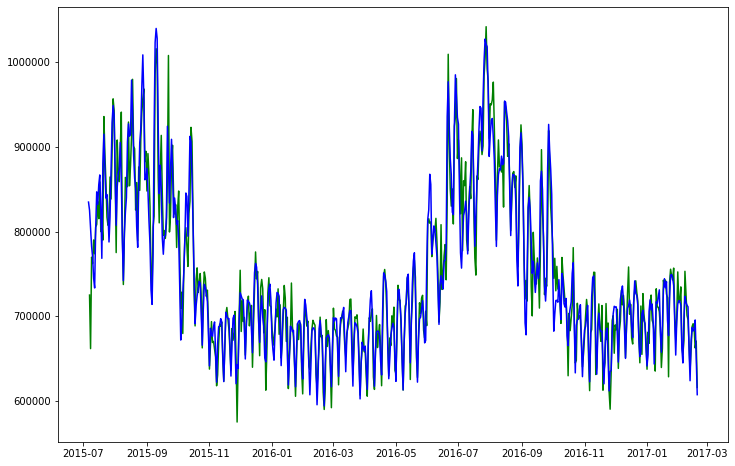

In [54]:
fig = plt.figure(figsize=[12, 8])

#plt.ylim(25000, 55000)

plt.plot(demand_hat3[1:], c='g')
plt.plot(X_train.index, X_train['day_demand'].values, c='b')

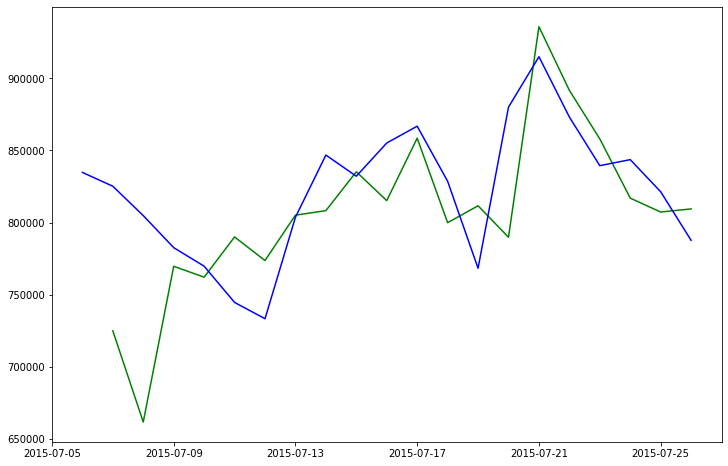

In [55]:
fig = plt.figure(figsize=[12, 8])

#plt.ylim(0, 55000)

plt.plot(demand_hat3[1:21], label='Prediction', c='g')
actual = X_train['day_demand'].values
plt.plot(X_train.index[:21], X_train['day_demand'].values[:21], c='b', label='Actual')

In [56]:
# Save the trained model
filename = 'SARIMAX_w_xexog_day.sav'
pickle.dump(model3, open(filename, 'wb'))

In [57]:
predict_steps = 7*4
predict3 = res3.get_forecast(predict_steps, 
                exog=X_walk1[best_exog_columns3].values[:predict_steps, :])
pred_ci3 = np.exp(predict3.conf_int(alpha=0.5))
pred_vals3 = np.exp(predict3.predicted_mean)

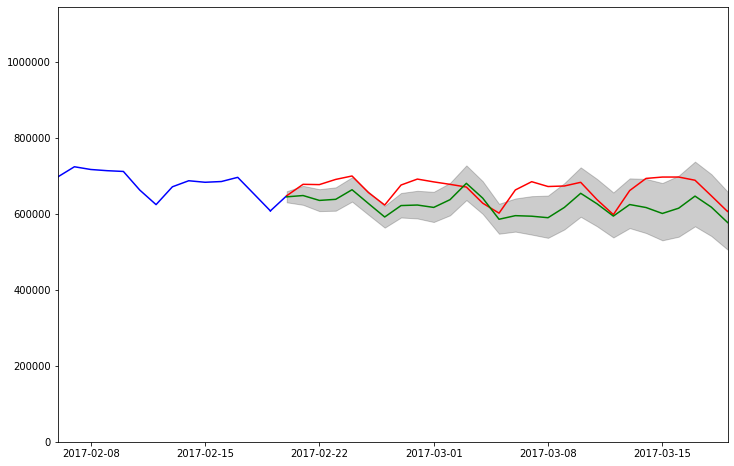

In [58]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(0, 15000)
date_list = X_train.index

low_values = pred_ci3.iloc[:, 0].values
high_values = pred_ci3.iloc[:, 1].values
pred_times3 = pred_ci3.index

plt.xlim(min(date_list[int(-0.5*predict_steps):]), max(pred_times3))
plt.ylim(0, max([max(high_values), 1.1*max(max(X_train['day_demand']), max(X_walk1['day_demand']))]))

plt.plot(X_train.index[-2*predict_steps:], X_train['day_demand'].values[-2*predict_steps:], c='b')
plt.plot([X_train.index[-1], X_walk1['day_demand'].index[0]], \
          [X_train['day_demand'].values[-1], X_walk1['day_demand'].values[0]], c='b')
plt.plot(X_walk1.index, X_walk1['day_demand'].values, c='r')
plt.plot(pred_times3, pred_vals3.values, c='g')


plt.fill_between(pred_times3, low_values, high_values, color='k', alpha=0.2)

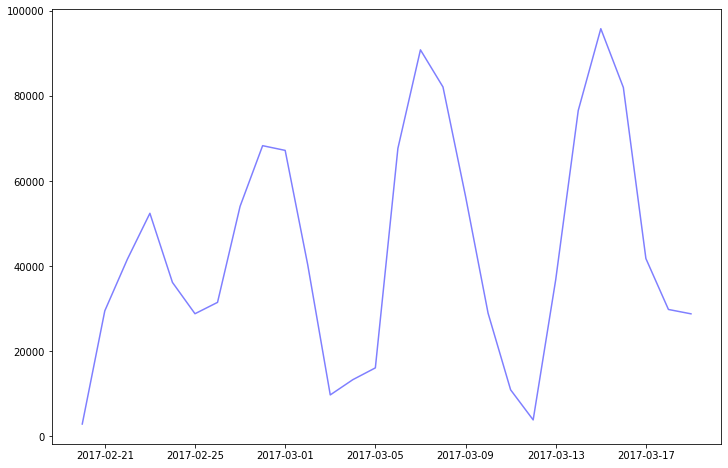

In [59]:
fig = plt.figure(figsize=[12, 8])
residuals3 = [abs(X_walk1['day_demand'].values[x] - pred_vals3.values[x]) for x in range(len(pred_vals3))]
plt.plot(pred_times3, residuals3, c='b', alpha=0.5)
#plt.ylim(0, 10000)

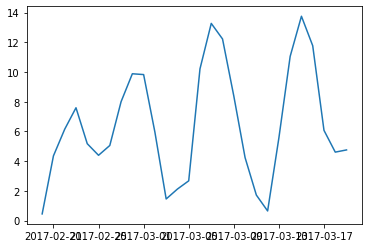

In [60]:
residuals = [abs(X_walk1['day_demand'].values[x] - pred_vals3.values[x]) for x in range(len(pred_vals3))]
percent_error = [residuals[x]/X_walk1['day_demand'].values[x]*100 for x in range(len(residuals))]
plt.plot(pred_times3, percent_error)
#plt.ylim(0, 7000)

In [61]:
mape3 = np.mean(percent_error[:21])
print(mape3)

5.891213508451026


----
----
#### Walk Forward
----

In [24]:
X_train = X_train.append(X_walk1)
# Add Log_demand to the dataframe
X_train['log_demand'] = np.log(X_train['day_demand'])

In [63]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 680 entries, 2015-07-06 to 2017-05-15
Data columns (total 14 columns):
CA_pop        680 non-null float64
DOW           680 non-null float64
Fri           680 non-null uint8
Mon           680 non-null uint8
Sat           680 non-null uint8
Sun           680 non-null uint8
Thur          680 non-null uint8
Tue           680 non-null uint8
Wed           680 non-null uint8
day_demand    680 non-null float64
f_high        680 non-null float64
la_high       680 non-null float64
log_demand    680 non-null float64
sd_high       680 non-null float64
dtypes: float64(7), uint8(7)
memory usage: 47.1 KB


In [64]:
# Now choose the results that seem to work the best above and fit the model
model1 = SARIMAX(X_train['log_demand'], order=best_order1, seasonal_order=best_seasonal_order1)
res1 = model1.fit()

In [65]:
predict_steps = 7*3
predict1 = res1.get_forecast(predict_steps)
pred_ci1 = np.exp(predict1.conf_int(alpha=0.5))
pred_vals1 = np.exp(predict1.predicted_mean)

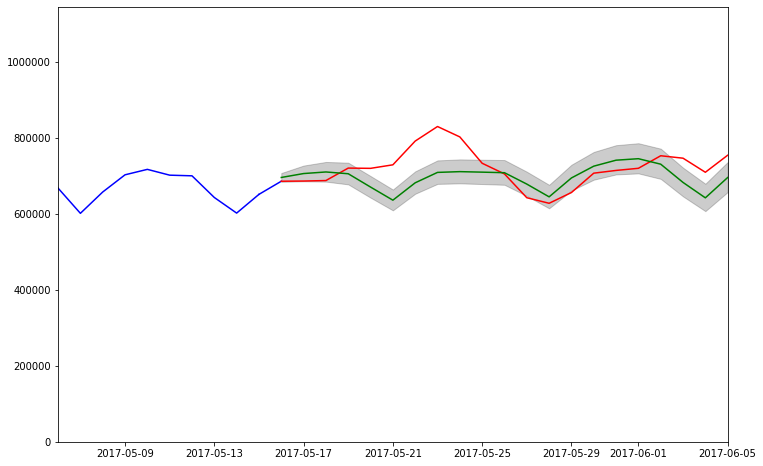

In [66]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(0, 15000)
date_list = X_train.index

low_values = pred_ci1.iloc[:, 0].values
high_values = pred_ci1.iloc[:, 1].values
pred_times1 = pred_ci1.index

plt.xlim(min(date_list[int(-0.5*predict_steps):]), max(pred_times1))
plt.ylim(0, max([max(high_values), 1.1*max(max(X_train['day_demand']), max(X_walk2['day_demand']))]))

plt.plot(X_train.index[-2*predict_steps:], X_train['day_demand'].values[-2*predict_steps:], c='b')
plt.plot([X_train.index[-1], X_walk2['day_demand'].index[0]], \
          [X_train['day_demand'].values[-1], X_walk2['day_demand'].values[0]], c='b')
plt.plot(X_walk2.index, X_walk2['day_demand'].values, c='r')
plt.plot(pred_times1, pred_vals1.values, c='g')


plt.fill_between(pred_times1, low_values, high_values, color='k', alpha=0.2)

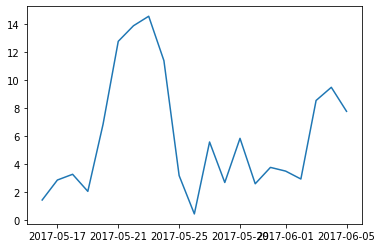

In [67]:
residuals = [abs(X_walk2['day_demand'].values[x] - pred_vals1.values[x]) for x in range(len(pred_vals1))]
percent_error = [residuals[x]/X_walk2['day_demand'].values[x]*100 for x in range(len(residuals))]
plt.plot(pred_times1, percent_error)
#plt.ylim(0, 7000)

In [26]:
# Now choose the results that seem to work the best above and fit the model
best_exog_columns3 = ['la_high','f_high']
best_order3 = (5, 0, 0)
best_seasonal_order3 = (3, 0, 1, 7)
model3 = SARIMAX(X_train['log_demand'], order=best_order3, \
            seasonal_order=best_seasonal_order3, exog=X_train[best_exog_columns3])
res3 = model3.fit()

In [69]:
predict_steps = 7*3
predict3 = res3.get_forecast(predict_steps, 
                exog=X_walk1[best_exog_columns3].values[:predict_steps, :])
pred_ci3 = np.exp(predict3.conf_int(alpha=0.5))
pred_vals3 = np.exp(predict3.predicted_mean)

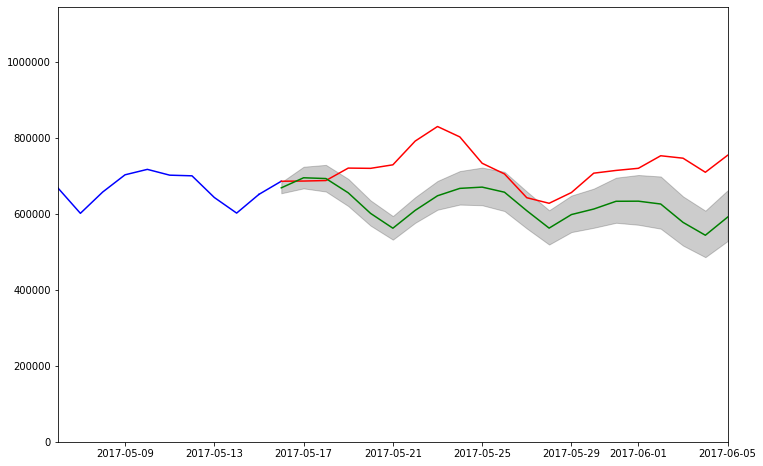

In [70]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(0, 15000)
date_list = X_train.index

low_values = pred_ci3.iloc[:, 0].values
high_values = pred_ci3.iloc[:, 1].values
pred_times3 = pred_ci3.index

plt.xlim(min(date_list[int(-0.5*predict_steps):]), max(pred_times3))
plt.ylim(0, max([max(high_values), 1.1*max(max(X_train['day_demand']), max(X_walk2['day_demand']))]))

plt.plot(X_train.index[-2*predict_steps:], X_train['day_demand'].values[-2*predict_steps:], c='b')
plt.plot([X_train.index[-1], X_walk2['day_demand'].index[0]], \
          [X_train['day_demand'].values[-1], X_walk2['day_demand'].values[0]], c='b')
plt.plot(X_walk2.index, X_walk2['day_demand'].values, c='r')
plt.plot(pred_times3, pred_vals3.values, c='g')


plt.fill_between(pred_times3, low_values, high_values, color='k', alpha=0.2)

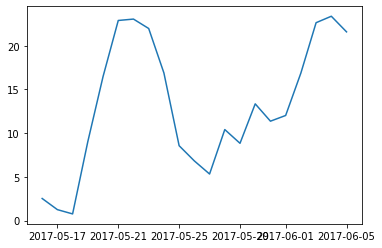

In [71]:
residuals = [abs(X_walk2['day_demand'].values[x] - pred_vals3.values[x]) for x in range(len(pred_vals3))]
percent_error = [residuals[x]/X_walk2['day_demand'].values[x]*100 for x in range(len(residuals))]
plt.plot(pred_times3, percent_error)
#plt.ylim(0, 7000)

In [74]:
mape22 = np.mean(percent_error[:21])
print(mape22)

13.141280095824474


----
----
### Walk 2
---

In [75]:
X_train = X_train.append(X_walk2)
# Add Log_demand to the dataframe
X_train['log_demand'] = np.log(X_train['day_demand'])

In [76]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 850 entries, 2015-07-06 to 2017-08-08
Data columns (total 14 columns):
CA_pop        850 non-null float64
DOW           850 non-null float64
Fri           850 non-null uint8
Mon           850 non-null uint8
Sat           850 non-null uint8
Sun           850 non-null uint8
Thur          850 non-null uint8
Tue           850 non-null uint8
Wed           850 non-null uint8
day_demand    850 non-null float64
f_high        850 non-null float64
la_high       850 non-null float64
log_demand    850 non-null float64
sd_high       850 non-null float64
dtypes: float64(7), uint8(7)
memory usage: 58.9 KB


In [77]:
# Now choose the results that seem to work the best above and fit the model
model1 = SARIMAX(X_train['log_demand'], order=best_order1, seasonal_order=best_seasonal_order1)
res1 = model1.fit()

In [78]:
predict_steps = 7*3
predict1 = res1.get_forecast(predict_steps)
pred_ci1 = np.exp(predict1.conf_int(alpha=0.5))
pred_vals1 = np.exp(predict1.predicted_mean)

In [90]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(0, 15000)
date_list = X_train.index

low_values = pred_ci1.iloc[:, 0].values
high_values = pred_ci1.iloc[:, 1].values
pred_times1 = pred_ci1.index

#plt.xlim(min(date_list[int(-0.5*predict_steps):]), max(pred_times1))
plt.ylim(0, max([max(high_values), 1.1*max(max(X_train['day_demand']), max(X_walk2['day_demand']))]))

plt.plot(X_train.index[-2*predict_steps:], X_train['day_demand'].values[-2*predict_steps:], c='b')
plt.plot([X_train.index[-1], X_walk3['day_demand'].index[0]], \
         [X_train['day_demand'].values[-1], X_walk3['day_demand'].values[0]], c='b')
plt.plot(X_walk3.index, X_walk3['day_demand'].values, c='r')
plt.plot(pred_times1, pred_vals1.values, c='g')


plt.fill_between(pred_times1, low_values, high_values, color='k', alpha=0.2)

ValueError: view limit minimum -35939.200000000004 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

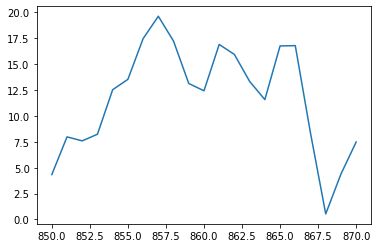

In [91]:
residuals = [abs(X_walk3['day_demand'].values[x] - pred_vals1.values[x]) for x in range(len(pred_vals1))]
percent_error = [residuals[x]/X_walk3['day_demand'].values[x]*100 for x in range(len(residuals))]
plt.plot(pred_times1, percent_error)
#plt.ylim(0, 7000)

In [93]:
mape33 = np.mean(percent_error[:21])
print(mape33)

11.717834045163718


In [94]:
# Now choose the results that seem to work the best above and fit the model
model3 = SARIMAX(X_train['log_demand'], order=best_order3, seasonal_order=best_seasonal_order3, \
            exog=X_train[best_exog_columns3])
res3 = model3.fit()

In [95]:
predict_steps = 7*3
predict3 = res3.get_forecast(predict_steps, 
                exog=X_walk1[best_exog_columns3].values[:predict_steps, :])
pred_ci3 = np.exp(predict3.conf_int(alpha=0.5))
pred_vals3 = np.exp(predict3.predicted_mean)

In [96]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(0, 15000)
date_list = X_train.index

low_values = pred_ci3.iloc[:, 0].values
high_values = pred_ci3.iloc[:, 1].values
pred_times3 = pred_ci3.index

plt.xlim(min(date_list[int(-0.5*predict_steps):]), max(pred_times3))
plt.ylim(0, max([max(high_values), 1.1*max(max(X_train['day_demand']), max(X_walk3['day_demand']))]))

plt.plot(X_train.index[-2*predict_steps:], X_train['day_demand'].values[-2*predict_steps:], c='b')
plt.plot([X_train.index[-1], X_walk3['day_demand'].index[0]], \
          [X_train['day_demand'].values[-1], X_walk3['day_demand'].values[0]], c='b')
plt.plot(X_walk3.index, X_walk3['day_demand'].values, c='r')
plt.plot(pred_times3, pred_vals3.values, c='g')


plt.fill_between(pred_times3, low_values, high_values, color='k', alpha=0.2)

ValueError: year 0 is out of range

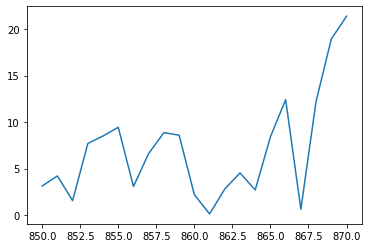

In [97]:
residuals = [abs(X_walk3['day_demand'].values[x] - pred_vals3.values[x]) for x in range(len(pred_vals3))]
percent_error = [residuals[x]/X_walk3['day_demand'].values[x]*100 for x in range(len(residuals))]
plt.plot(pred_times3, percent_error)
#plt.ylim(0, 7000)

In [98]:
mape3_3 = np.mean(percent_error[:21])
print(mape3_3)

7.049211671614031
